NOTEBOOK TO EXPLORE & CLEAN DATA

In [2]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=5f3b21459d00273d0e014fdc753433f9c85a8de60dbec8d4026022cb7780dfd6
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [3]:
import pandas as pd
from langdetect import detect
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import os
from google.colab import drive

In [4]:
#set up drive
drive.mount('/content/drive/')
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ML_Final_Project'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
path = GOOGLE_DRIVE_PATH + '/data/train-00000-of-00001-290868f0a36350c5.parquet'

Mounted at /content/drive/


In [5]:
#read in data to df
news_df = pd.read_parquet(path)

In [6]:
#initial cleaning
news_filter_df = news_df.copy()
news_filter_df = news_filter_df[news_filter_df["title"].notnull()]
news_filter_df = news_filter_df[news_filter_df["text"].notnull()]
news_filter_df = news_filter_df[(news_filter_df["text"] != " ") & (news_filter_df["text"] != "  ")]
news_filter_df = news_filter_df[news_filter_df.text != '\n']
news_filter_df = news_filter_df[news_filter_df.text != 'No.']
news_filter_df

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [7]:
#func to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

In [8]:
news_filter_df['lang'] = news_filter_df.title.apply(detect_language)

In [10]:
#second language detect on the text feautre for the instances not originally detected as english on the title
lang_check_df = news_filter_df.copy()
lang_check_df = lang_check_df[lang_check_df.lang != "en"]

lang_check_df['second_lang'] = lang_check_df['text'].apply(detect_language)

not_eng_df = lang_check_df[lang_check_df['second_lang'] != 'en']

to_drop_index = not_eng_df.index.to_list() #final list of the indicies that are not english to drop

In [11]:
def remove_punctuation(text):
    punctuation_pattern = r'[^\w\s]'
    text = re.sub(punctuation_pattern, '', text)
    return text

In [12]:
#more cleaning: drop non-english, lower case, remove punctuation
final_filter_df = news_filter_df.copy()
final_filter_df = final_filter_df.drop(to_drop_index)
final_filter_df = final_filter_df.drop('lang', axis=1)
final_filter_df = final_filter_df.reset_index(drop=True)
final_filter_df['title'] = final_filter_df['title'].str.lower()
final_filter_df['text'] = final_filter_df['text'].str.lower()
final_filter_df['text'] = final_filter_df['text'].str.replace('\n', '')
final_filter_df['title'] = final_filter_df['title'].str.replace('\n', '')
final_filter_df['title'] = final_filter_df.title.apply(remove_punctuation)
final_filter_df['text'] = final_filter_df.text.apply(remove_punctuation)
final_filter_df

,title,text,label
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1
1,unbelievable obamas attorney general says most...,now most of the demonstrators gathered last n...,1
2,bobby jindal raised hindu uses story of christ...,a dozen politically active pastors came here f...,0
3,satan 2 russia unvelis an image of its terrify...,the rs28 sarmat missile dubbed satan 2 will re...,1
4,about time christian group sues amazon and spl...,all we can say on this one is it s about time ...,1
...,...,...,...
70325,russians steal research on trump in hack of us...,washington reuters hackers believed to be wor...,0
70326,watch giuliani demands that democrats apologi...,you know because in fantasyland republicans ne...,1
70327,migrants refuse to leave train at refugee camp...,migrants refuse to leave train at refugee camp...,0
70328,trump tussle gives unpopular mexican leader mu...,mexico city reuters donald trumps combative s...,0


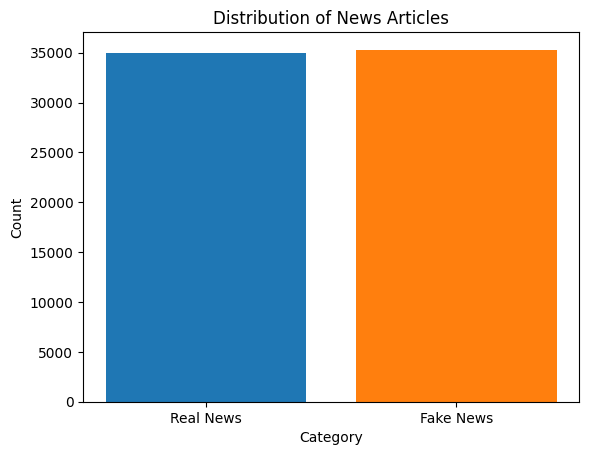

In [13]:
#looking at distribution of fake vs. real news in entire dataset:
val_count = final_filter_df.label.value_counts()
val_count_dict = {'Real News': val_count.loc[0], 'Fake News': val_count.loc[1]}

labels = list(val_count_dict.keys())
counts = list(val_count_dict.values())
colors = ['#1f77b4', '#ff7f0e']
plt.bar(labels, counts, color=colors)
plt.title('Distribution of News Articles')
plt.xlabel('Category')
plt.ylabel('Count')

plt.show()

In [14]:
#train/test split:
train_data_temp, test_data = train_test_split(final_filter_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data_temp, test_size=0.25, random_state=42)

Looking at length of text/title

In [15]:
#func to tokenize the data
def tokenize_dict(df):
    token_dict = {}
    for index in df.index:
        title_tokens = df['title'][index].split()
        text_tokens = df['text'][index].split()
        label = df['label'][index]
        token_dict[index] = {'title_tokens': title_tokens, 'text_tokens': text_tokens, 'label': label}
    return token_dict

In [16]:
#tokenize the data
train_dict = tokenize_dict(train_data)

#create dictionaries for the tokenized data (one for real news, one for fake news)
#note: these dictionaries still include stop words
train_dict_real = {key: value for key, value in train_dict.items() if value['label'] == 0}
train_dict_fake = {key: value for key, value in train_dict.items() if value['label'] == 1}

In [17]:
#checking for empty tokens (this is a check for an issue I had found at one point)
articles_with_empty_text_fake = []
articles_with_empty_text_real = []

for index, article in train_dict_real.items():
    if not article['text_tokens']:
        articles_with_empty_text_real.append(index)

for index, article in train_dict_fake.items():
    if not article['text_tokens']:
        articles_with_empty_text_fake.append(index)

print(articles_with_empty_text_fake)
print(articles_with_empty_text_real)

[]
[]


In [18]:
#func to calculate the num of words in title and text and to calculate num of unique words in title and text
def word_counts(data_dict):
    word_count_dict = {}
    for key, value in data_dict.items():
        title_tokens = value['title_tokens']
        text_tokens = value['text_tokens']

        num_words_title = len(title_tokens)
        num_unique_words_title = len(set(title_tokens))
        num_words_text = len(text_tokens)
        num_unique_words_text = len(set(text_tokens))

        word_count_dict[key] = {'title_num': num_words_title, 'title_unique': num_unique_words_title,
                                'text_num': num_words_text, 'text_unique':num_unique_words_text}

    return word_count_dict

In [19]:
#dictionaries with word counts & unique word counts for title and text
real_word_count_dict = word_counts(train_dict_real)
fake_word_count_dict = word_counts(train_dict_fake)

#dataframes of the dictionaries
real_word_count_df = pd.DataFrame.from_dict(real_word_count_dict, orient='index')
fake_word_count_df = pd.DataFrame.from_dict(fake_word_count_dict, orient='index')

#sorted series for real news
real_title_num_series = real_word_count_df.title_num.value_counts().sort_index()
real_text_num_series = real_word_count_df.text_num.value_counts().sort_index()
real_title_unique_series = real_word_count_df.title_unique.value_counts().sort_index()
real_text_unique_series = real_word_count_df.text_unique.value_counts().sort_index()

#sorted series for fake news
fake_title_num_series = fake_word_count_df.title_num.value_counts().sort_index()
fake_text_num_series = fake_word_count_df.text_num.value_counts().sort_index()
fake_title_unique_series = fake_word_count_df.title_unique.value_counts().sort_index()
fake_text_unique_series = fake_word_count_df.text_unique.value_counts().sort_index()

Looking at article titles:

Plot comparing number of words in real vs. fake titles:

Text(0.5, 1.0, 'Distribution of Article Title Length: Real vs. Fake News')

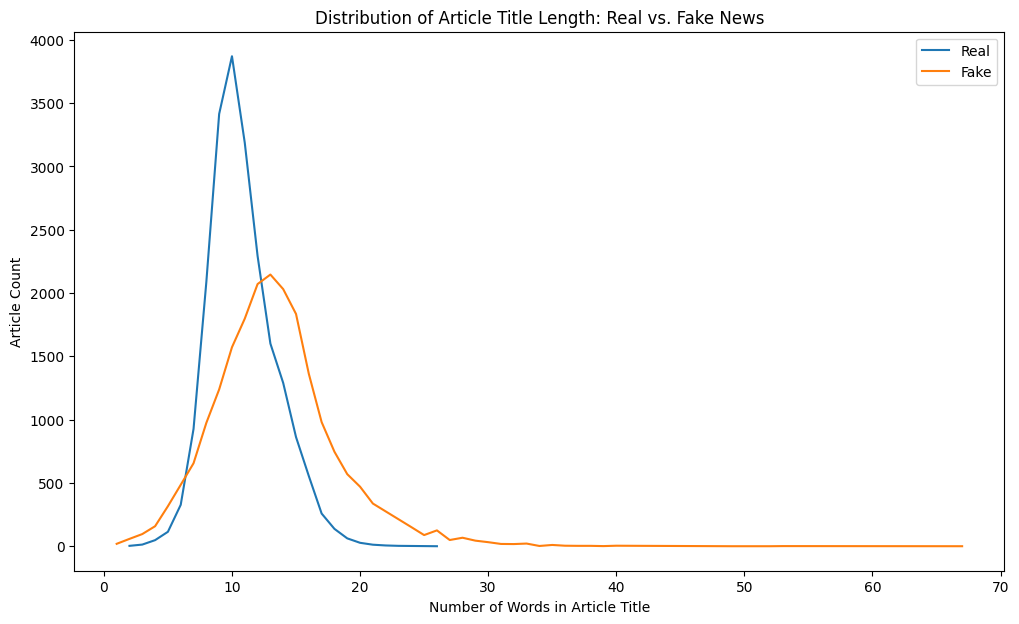

In [20]:
plt.figure(figsize=(12,7))
real_title_num_series.plot(kind='line', label="Real")
fake_title_num_series.plot(kind='line', label='Fake')
plt.legend()
plt.xlabel('Number of Words in Article Title')
plt.ylabel('Article Count')
plt.title('Distribution of Article Title Length: Real vs. Fake News')

plot comparing number of unique words in real vs. fake titles:

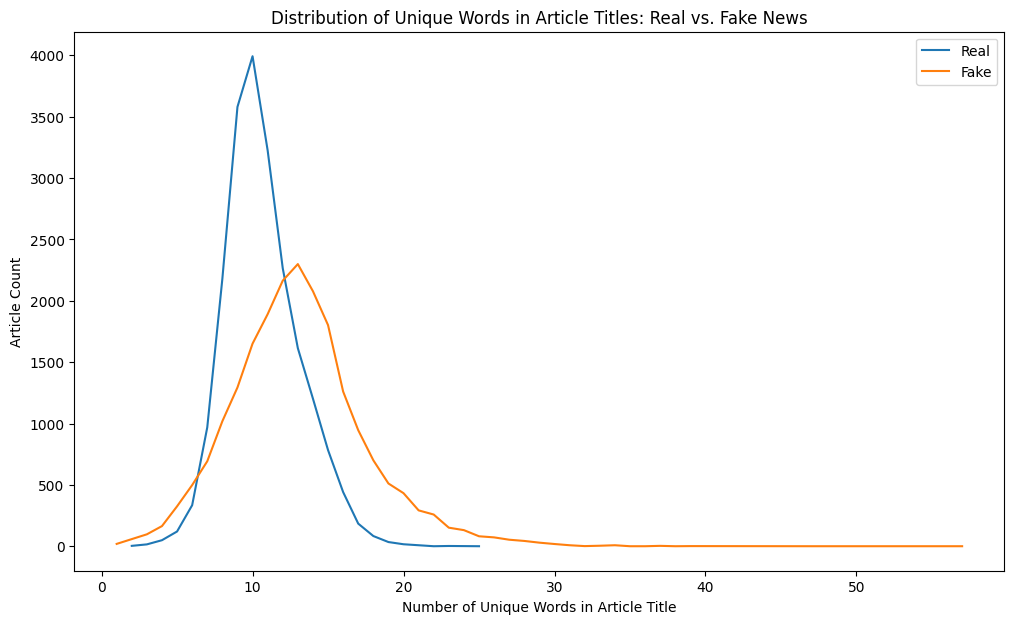

In [21]:
plt.figure(figsize=(12,7))
real_title_unique_series.plot(kind='line', label="Real")
fake_title_unique_series.plot(kind='line', label='Fake')
plt.legend()
plt.xlabel('Number of Unique Words in Article Title')
plt.ylabel('Article Count')
plt.title('Distribution of Unique Words in Article Titles: Real vs. Fake News');

Looking at article text:

Plot comparing the number of words in real vs. fake text:

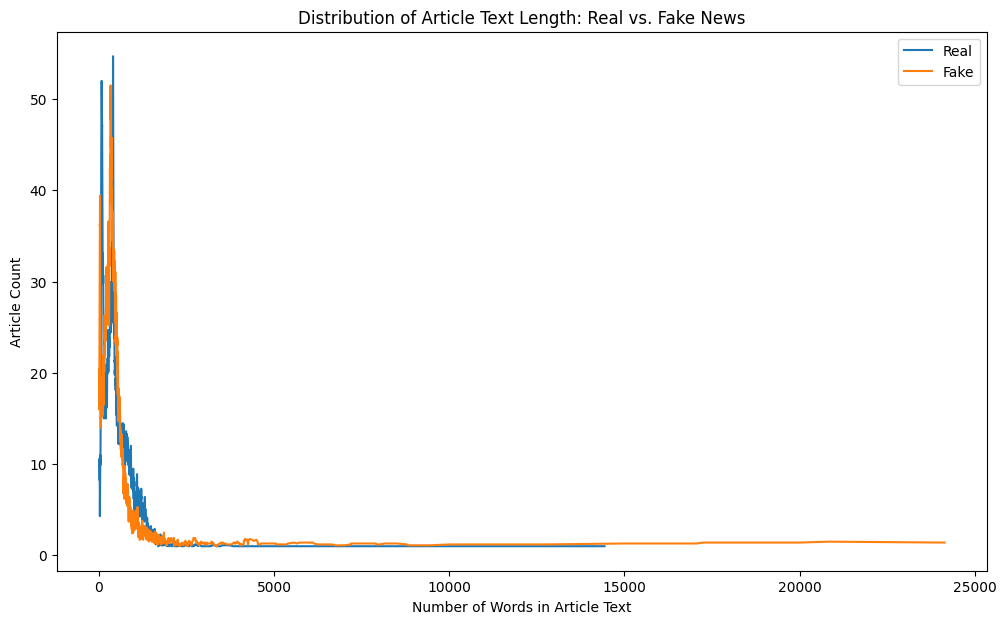

In [22]:
smoothed_real_text = real_text_num_series.rolling(window=10).mean()
smoothed_fake_text = fake_text_num_series.rolling(window=10).mean()

plt.figure(figsize=(12,7))
plt.plot(smoothed_real_text, label='Real')
plt.plot(smoothed_fake_text, label='Fake')
plt.legend()
plt.title('Distribution of Article Text Length: Real vs. Fake News')
plt.xlabel('Number of Words in Article Text')
plt.ylabel('Article Count')
plt.show()

plot comparing the number of unique words in real vs. fake text:

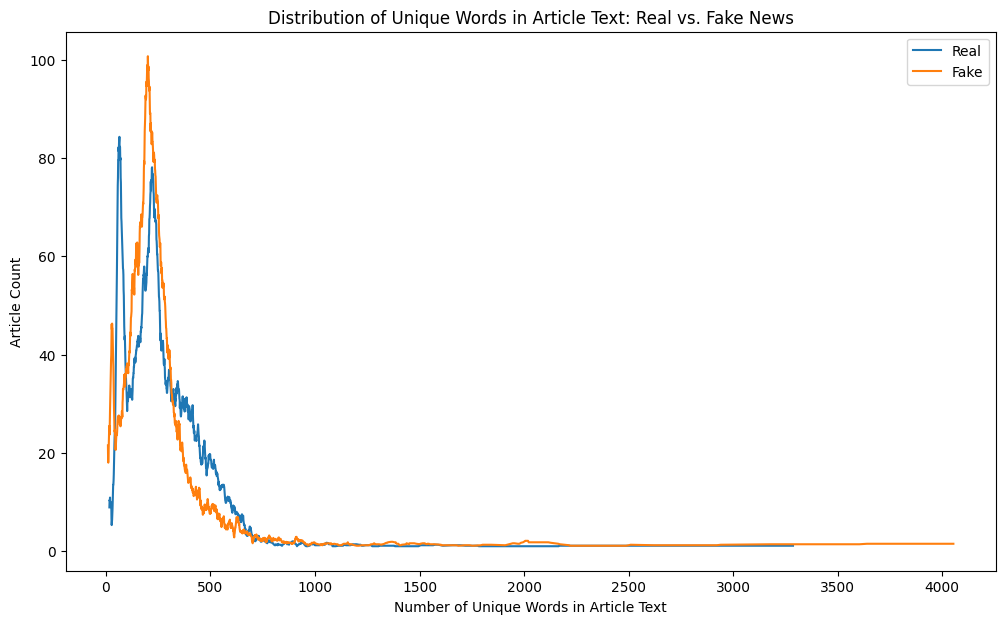

In [23]:
smoothed_real_text_unique = real_text_unique_series.rolling(window=10).mean()
smoothed_fake_text_unique = fake_text_unique_series.rolling(window=10).mean()

plt.figure(figsize=(12,7))
plt.plot(smoothed_real_text_unique, label='Real')
plt.plot(smoothed_fake_text_unique, label='Fake')
plt.legend()
plt.title('Distribution of Unique Words in Article Text: Real vs. Fake News')
plt.xlabel('Number of Unique Words in Article Text')
plt.ylabel('Article Count')
plt.show()

Removing stop words (and replicating previous process):

In [24]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#remove stop words from dictionaries
def remove_stop_words(data_dict):
    new_dict = data_dict.copy()
    for key, value in data_dict.items():
        filtered_text_tokens = [word for word in value['text_tokens'] if word not in stop_words]
        filtered_title_tokens = [word for word in value['title_tokens'] if word not in stop_words]

        new_dict[key]['text_tokens'] = filtered_text_tokens
        new_dict[key]['title_tokens'] = filtered_title_tokens

    return new_dict

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
#remove stop words from the real and fake dictionaries:
train_dict_fake_sw = remove_stop_words(train_dict_fake)
train_dict_real_sw = remove_stop_words(train_dict_real)

In [26]:
#replicating word counts as before:

#dictionaries with word counts & unique word counts for title and text
real_word_count_sw_dict = word_counts(train_dict_real_sw)
fake_word_count_sw_dict = word_counts(train_dict_fake_sw)
#dataframes of the dictionaries
real_word_count_sw_df = pd.DataFrame.from_dict(real_word_count_sw_dict, orient='index')
fake_word_count_sw_df = pd.DataFrame.from_dict(fake_word_count_sw_dict, orient='index')


#sortd series for real articles:
real_title_num_sw_series = real_word_count_sw_df.title_num.value_counts().sort_index()
real_text_num_sw_series = real_word_count_sw_df.text_num.value_counts().sort_index()

real_title_unique_sw_series = real_word_count_sw_df.title_unique.value_counts().sort_index()
real_text_unique_sw_series = real_word_count_sw_df.text_unique.value_counts().sort_index()


#sorted series for fake articles:
fake_title_num_sw_series = fake_word_count_sw_df.title_num.value_counts().sort_index()
fake_text_num_sw_series = fake_word_count_sw_df.text_num.value_counts().sort_index()

fake_title_unique_sw_series = fake_word_count_sw_df.title_unique.value_counts().sort_index()
fake_text_unique_sw_series = fake_word_count_sw_df.text_unique.value_counts().sort_index()

plot comparing number of words in real vs. fake titles (w/out stop words)

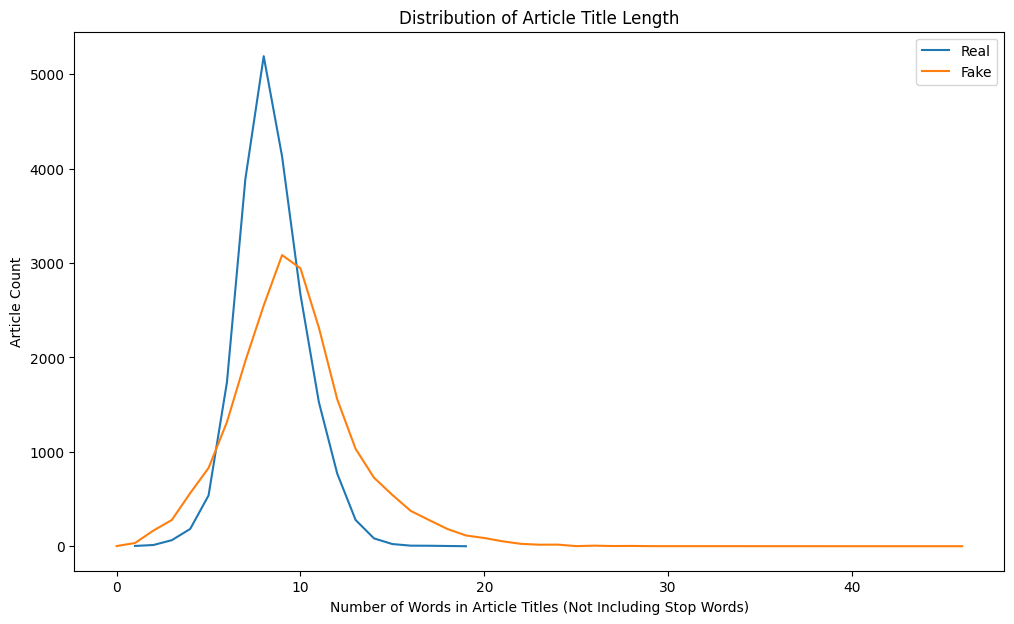

In [27]:
plt.figure(figsize=(12,7))
real_title_num_sw_series.plot(kind='line', label="Real")
fake_title_num_sw_series.plot(kind='line', label='Fake')
plt.legend()
plt.xlabel('Number of Words in Article Titles (Not Including Stop Words)')
plt.ylabel('Article Count')
plt.title('Distribution of Article Title Length');

plot comparing number of unique words in real vs. fake titles (w/out stop words)

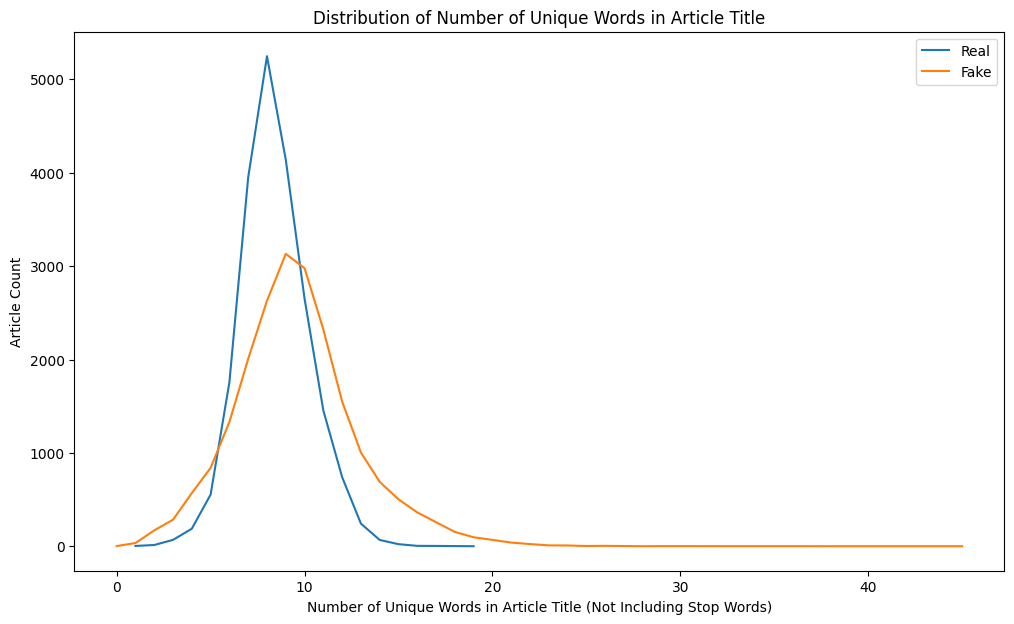

In [28]:
plt.figure(figsize=(12,7))
real_title_unique_sw_series.plot(kind='line', label="Real")
fake_title_unique_sw_series.plot(kind='line', label='Fake')
plt.legend()
plt.xlabel('Number of Unique Words in Article Title (Not Including Stop Words)')
plt.ylabel('Article Count')
plt.title('Distribution of Number of Unique Words in Article Title');

comparing number of words in real vs. fake texts (w/out stop words)

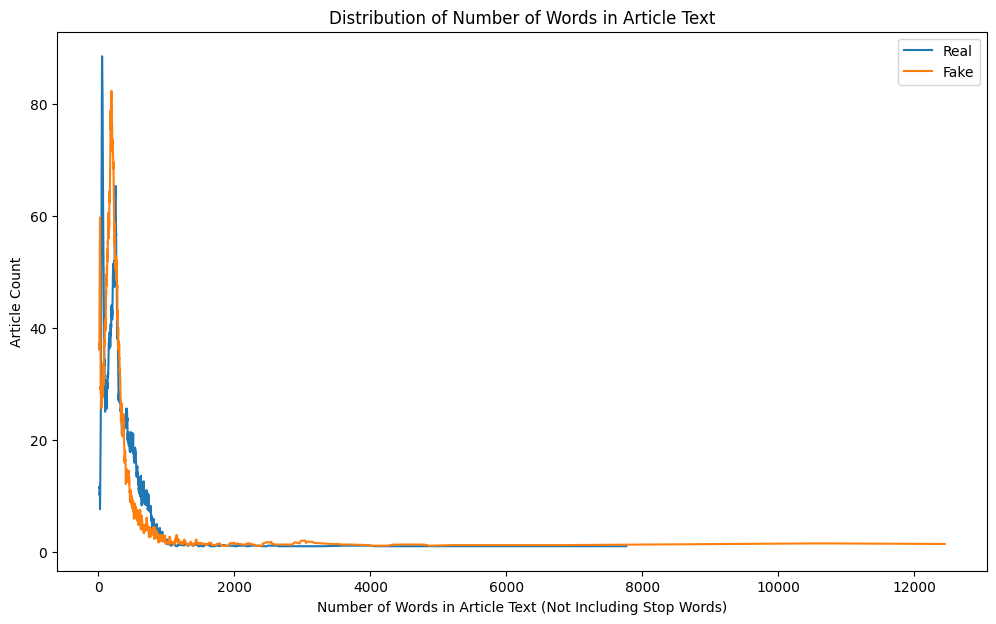

In [29]:
smoothed_real_text_sw = real_text_num_sw_series.rolling(window=10).mean()
smoothed_fake_text_sw = fake_text_num_sw_series.rolling(window=10).mean()

plt.figure(figsize=(12,7))
plt.plot(smoothed_real_text_sw, label='Real')
plt.plot(smoothed_fake_text_sw, label='Fake')
plt.legend()
plt.title('Distribution of Number of Words in Article Text')
plt.xlabel('Number of Words in Article Text (Not Including Stop Words)')
plt.ylabel('Article Count')
plt.show()

comparing number of unique words in real vs. fake texts (w/out stop words):

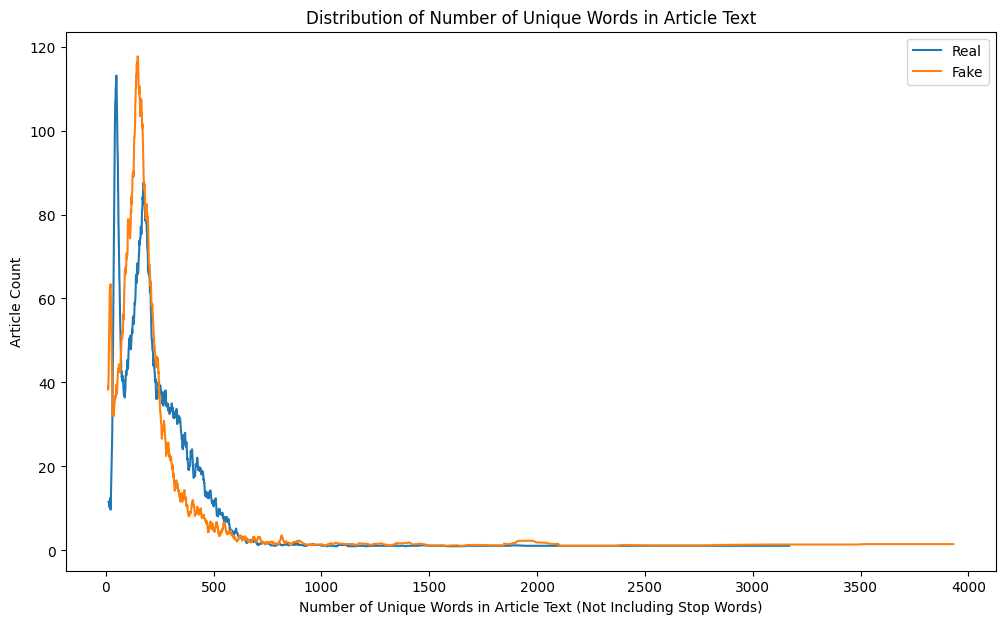

In [30]:
smoothed_real_text_unique_sw = real_text_unique_sw_series.rolling(window=10).mean()
smoothed_fake_text_unique_sw = fake_text_unique_sw_series.rolling(window=10).mean()

plt.figure(figsize=(12,7))
plt.plot(smoothed_real_text_unique_sw, label='Real')
plt.plot(smoothed_fake_text_unique_sw, label='Fake')
plt.legend()
plt.title('Distribution of Number of Unique Words in Article Text')
plt.xlabel('Number of Unique Words in Article Text (Not Including Stop Words)')
plt.ylabel('Article Count')
plt.show()

Looking at most frequently used words for real vs. fake news:

In [31]:
#remove stop words from a dataframe
def remove_stopwords(text_data):
    tokens = word_tokenize(text_data)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

In [33]:
#removing stop words from the train data:
nltk.download('punkt')
train_no_stop_df = train_data.copy()
train_no_stop_df['title'] = train_no_stop_df['title'].apply(remove_stopwords)
train_no_stop_df['text'] = train_no_stop_df['text'].apply(remove_stopwords)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [34]:
#remove stop words from df for real and df for fake news:
train_real_df = train_no_stop_df.copy()
train_real_df = train_real_df[train_real_df.label == 0]

train_fake_df = train_no_stop_df.copy()
train_fake_df = train_fake_df[train_fake_df.label == 1]

In [35]:
#corpus for real news:
train_real_copy = train_real_df.copy()
train_real_copy['combo'] = train_real_copy.title + ' ' + train_real_copy.text
real_corpus = ' '.join(train_real_copy['combo'])
real_corpus_list = word_tokenize(real_corpus)

#corpus for fake news:
train_fake_copy = train_fake_df.copy()
train_fake_copy['combo'] = train_fake_copy.title + ' ' + train_fake_copy.text
fake_corpus = ' '.join(train_fake_copy['combo'])
fake_corpus_list = word_tokenize(fake_corpus)

In [36]:
#count words for real and fake news:
word_counts_real = Counter(real_corpus_list)
word_count_real_df = pd.DataFrame(list(word_counts_real.items()), columns=['word', 'count'])

word_counts_fake = Counter(fake_corpus_list)
word_count_fake_df = pd.DataFrame(list(word_counts_fake.items()), columns=['word', 'count'])

In [37]:
#top 25 words used in real news articles:
top25_real_df = word_count_real_df.sort_values(by='count', ascending=False).head(25)

#top 25 words used in fake news articles:
top25_fake_df = word_count_fake_df.sort_values(by='count', ascending=False).head(25)

In [38]:
#sets for the top 25 real and fake words:
fake_set = set(top25_fake_df.word)
real_set = set(top25_real_df.word)

#words that are in both real and fake top 25:
overlap = (fake_set & real_set)

#words only in real news top 25:
only_real = real_set - fake_set

#words only in the fake news top 25:
only_fake = fake_set - real_set

In [39]:
overlap

{'also',
 'clinton',
 'could',
 'like',
 'new',
 'one',
 'people',
 'president',
 'said',
 'state',
 'trump',
 'us',
 'would'}

In [40]:
only_fake

{'american',
 'donald',
 'election',
 'even',
 'get',
 'hillary',
 'many',
 'media',
 'news',
 'obama',
 'time',
 'white'}

In [41]:
only_real

{'government',
 'house',
 'last',
 'mr',
 'republican',
 'reuters',
 'states',
 'told',
 'trumps',
 'two',
 'united',
 'years'}